#  Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


## Loading the data from Sqlite file

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# General Packages
import os
import sqlite3
import pandas as pd
import numpy as np
import string
import re
import nltk

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for BOW (Bag of words)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# Packages for Text Preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#Packages for Word2vec, Average Word2vec & Tf-Idf Weighted Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

#Packages for plotting Tsne plot
from sklearn.manifold import TSNE

In [2]:
#Setting Parent Directory
os.chdir('/users/sujis/Downloads/Applied AI/')#C:\Users\sujit.venkata\Downloads\Dev & Imp works\Applied AI'

# using the SQLite Table to read data.
con = sqlite3.connect('/users/sujis/Downloads/Applied AI/amazon-fine-food-reviews/database.sqlite') 

In [3]:
# Filtering for the reviews those with Score= 3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Aliasing the Score to String Format (Positive for Score > 3 & Negative for Score  < 3)

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
# Size and Shape of the Data set & printing 5 records
print(filtered_data.shape) 
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


##  Exploratory Data Analysis

### Data Cleaning: Deduplication

In [5]:
# Checking for the Duplicate records

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="ABXLMWJIXXAIN"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,320691,B000CQ26E0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,4,1187740800,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ..."
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,468954,B004DMGQKE,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,5,1351209600,Awesome service and great products,We sent this product as a gift to my husband's...


<b>Observation:-</b>
    As per the result set of the query for userId='ABXLMWJIXXAIN', the same user has multiple reviews. So removing the duplicates are removed ensuring that there is only one review for each product by each user.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
# Percentage of data still left after Deduplication
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


<b>Observation:-</b> 
    It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
# Removing the records who have HelpfulnessNumerator less than HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [12]:
#nltk.download("stopwords")

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.



In [13]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
# Defining Functions to clean html tags & Punctuations
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(stop)

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [16]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [17]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

##  Bag of Words (BoW)

In [18]:
# Due to memory constraints taking 1.25k positive & 1.25k negative reviews
final_dataset=pd.DataFrame()
positive_dataset=final.loc[final['Score'] == 'positive'].head(1250)
Negative_dataset=final.loc[final['Score'] == 'negative'].head(1250)
final_dataset=pd.concat([positive_dataset,Negative_dataset])

In [19]:
l1 = positive_dataset['Score']
l2 = Negative_dataset['Score']
label=pd.concat([l1,l2])

In [20]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_dataset['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2500, 7937)
the number of unique words  7937


In [21]:
# Converting Sparse matric to array
final_counts=final_counts.toarray()

In [36]:
#tsne with perplexity = 0
model = TSNE(n_components=2, random_state=0, perplexity=0,  n_iter=5000)
tsne_data = model.fit_transform(final_counts)

In [37]:
tsne_data.shape

(2500, 2)

In [38]:
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

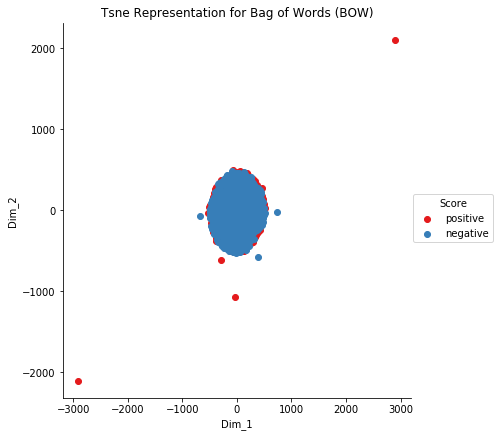

In [39]:
# Scatter plot representing 2 dimensions with the polarity
sns.FacetGrid(tsne_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for Bag of Words (BOW)')
plt.show()

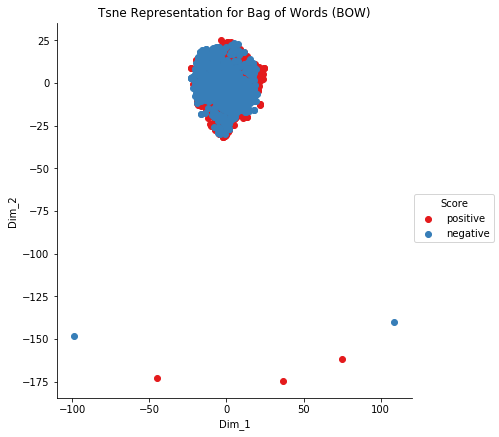

In [40]:
#tsne with perplexity = 30
model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=5000)
tsne_data = model.fit_transform(final_counts)
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# Scatter plot representing 2 dimensions with the polarity
sns.FacetGrid(tsne_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for Bag of Words (BOW)')
plt.show()

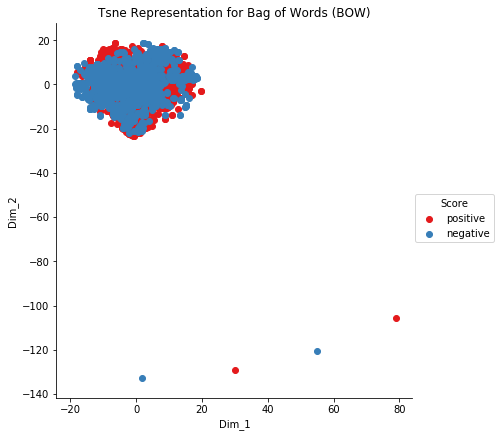

In [34]:
#tsne with perplexity = 0
model = TSNE(n_components=2, random_state=0, perplexity=40,  n_iter=5000)
tsne_data = model.fit_transform(final_counts)
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# Scatter plot representing 2 dimensions with the polarity
sns.FacetGrid(tsne_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for Bag of Words (BOW)')
plt.show()

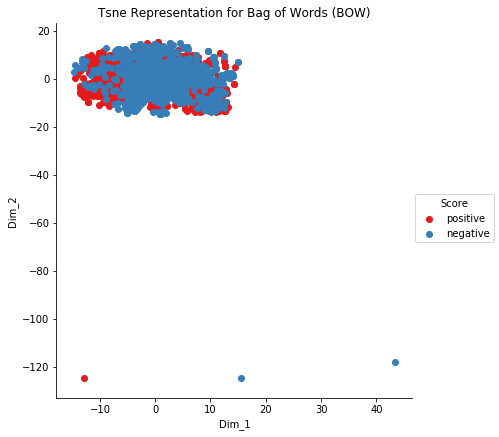

In [35]:
#tsne with perplexity = 50
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)
tsne_data = model.fit_transform(final_counts)
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# Scatter plot representing 2 dimensions with the polarity
sns.FacetGrid(tsne_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for Bag of Words (BOW)')
plt.show()

### Term Frequency– Inverse Document Frequency ( TF-IDF )

# Due to memory constraints taking 1.25k positive & 1.25k negative reviews

In [3]:
#Connecting the Sqlite file
con2 = sqlite3.connect('/users/sujis/Downloads/Applied AI/final.sqlite') 
final= pd.read_sql_query(""" SELECT * FROM Reviews """, con2) 

In [4]:
final_dataset=pd.DataFrame()
positive_dataset=final.loc[final['Score'] == 'positive'].head(1250)
Negative_dataset=final.loc[final['Score'] == 'negative'].head(1250)
final_dataset=pd.concat([positive_dataset,Negative_dataset])
l1 = positive_dataset['Score']
l2 = Negative_dataset['Score']
label=pd.concat([l1,l2])

In [6]:
# Configuring ngram range from unigram to bigram
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_dataset['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2500, 89432)
the number of unique words including both unigrams and bigrams  89432


In [8]:
# Converting Sparse matric to array
final_tf_idf=final_tf_idf.toarray()

In [8]:
#tsne with perplexity=0
model = TSNE(n_components=2, random_state=0,perplexity=0, n_iter=5000)
tsne_data_tfidf = model.fit_transform(final_tf_idf)

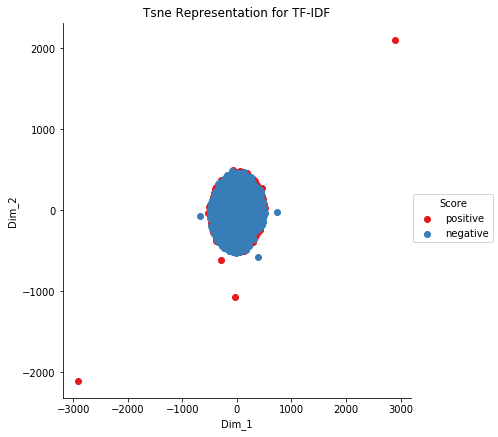

In [9]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, label)).T
tsne_tf_idf_df = pd.DataFrame(data=tsne_data_tfidf, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_tf_idf_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for TF-IDF')
plt.show()

In [10]:
#tsne with perplexity = 30
model = TSNE(n_components=2, random_state=0,perplexity=30, n_iter=5000)
tsne_data_tfidf = model.fit_transform(final_tf_idf)

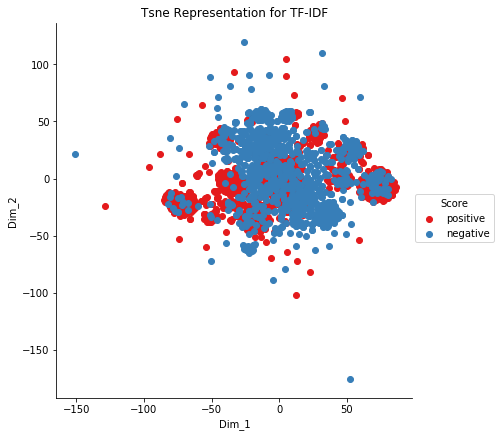

In [11]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, label)).T
tsne_tf_idf_df = pd.DataFrame(data=tsne_data_tfidf, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_tf_idf_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for TF-IDF')
plt.show()

In [9]:
#tsne with perplexity=40
model = TSNE(n_components=2, random_state=0,perplexity=40, n_iter=5000)
tsne_data_tfidf = model.fit_transform(final_tf_idf)

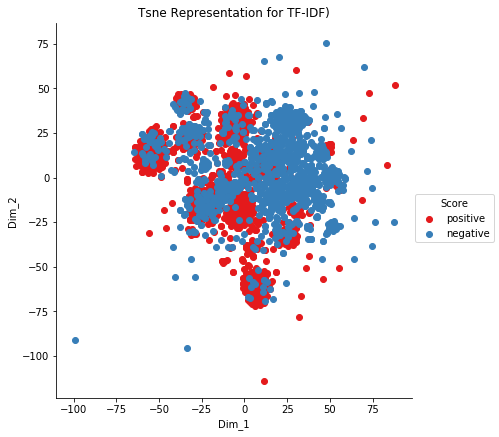

In [10]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, label)).T
tsne_tf_idf_df = pd.DataFrame(data=tsne_data_tfidf, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_tf_idf_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for TF-IDF)')
plt.show()

In [11]:
#tsne with perplexity=50
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)
tsne_data_tfidf = model.fit_transform(final_tf_idf)

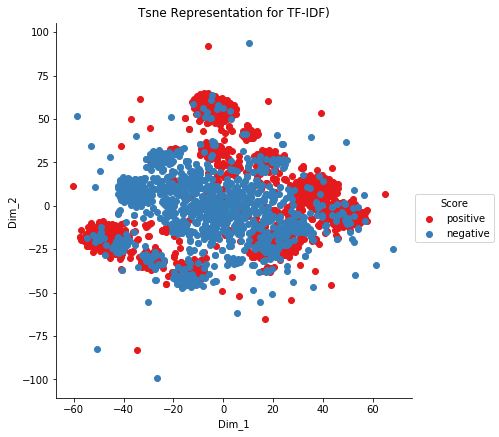

In [12]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, label)).T
tsne_tf_idf_df = pd.DataFrame(data=tsne_data_tfidf, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_tf_idf_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for TF-IDF)')
plt.show()

## Average Word2Vec ( Avg W2V )

# Due to memory constraints taking 1.25k positive & 1.25k negative reviews

In [13]:
# Connecting the Sqlite file
#con2 = sqlite3.connect('final.sqlite') 
#final = pd.read_sql_query(""" SELECT * FROM Reviews """, con2) 

In [14]:
#final_dataset=pd.DataFrame()
#positive_dataset=final.loc[final['Score'] == 'positive'].head(2500)
#Negative_dataset=final.loc[final['Score'] == 'negative'].head(2500)
#final_dataset=pd.concat([positive_dataset,Negative_dataset])
#l1 = positive_dataset['Score']
#l2 = Negative_dataset['Score']
#label=pd.concat([l1,l2])

In [15]:
# Word2Vec
#model = KeyedVectors.load_word2vec_format('google_w2v_for_amazon.pkl', binary=True)

In [16]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final_dataset['CleanedText'].values:
    list_of_sent.append(sent.split())

In [17]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [18]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2567
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'still', 'abl', 'memori', 'grew', 'read', 'sendak', 'watch', 'realli', 'movi', 'howev', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand', 'keep', 'page', 'open', 'fun', 'way', 'children', 'month', 'year', 'poem', 'throughout']


In [19]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))

2500


In [20]:
#tsne with perplexity=0
model = TSNE(n_components=2, random_state=0, perplexity=0, n_iter=5000)
tsne_data_Aw2v = model.fit_transform(sent_vectors)

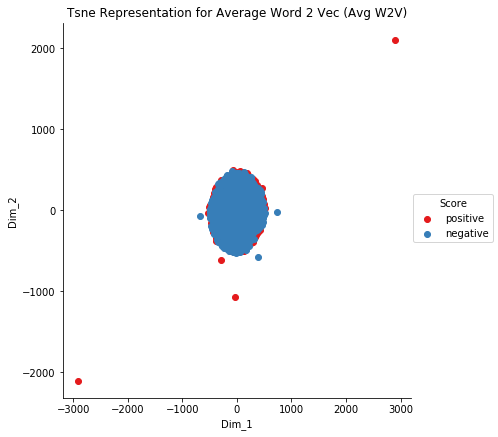

In [21]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_Aw2v = np.vstack((tsne_data_Aw2v.T, label)).T
tsne_data_Aw2v_df = pd.DataFrame(data=tsne_data_Aw2v, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_data_Aw2v_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for Average Word 2 Vec (Avg W2V)')
plt.show()

In [22]:
#tsne with perplexity= 30
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_data_Aw2v = model.fit_transform(sent_vectors)

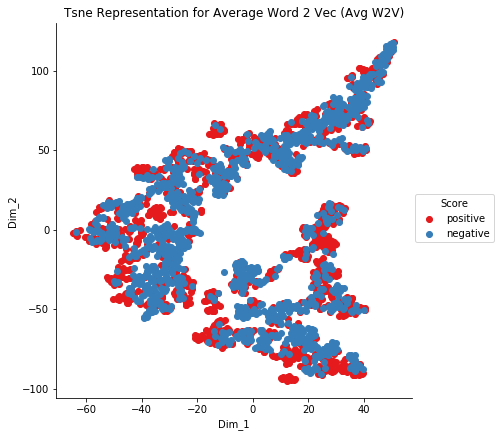

In [23]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_Aw2v = np.vstack((tsne_data_Aw2v.T, label)).T
tsne_data_Aw2v_df = pd.DataFrame(data=tsne_data_Aw2v, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_data_Aw2v_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for Average Word 2 Vec (Avg W2V)')
plt.show()

In [24]:
#tsne with perplexity=40
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=5000)
tsne_data_Aw2v = model.fit_transform(sent_vectors)

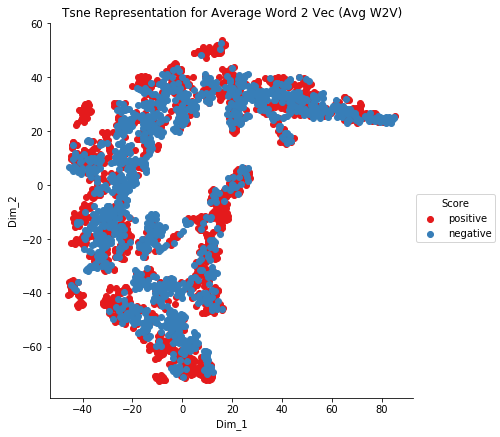

In [25]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_Aw2v = np.vstack((tsne_data_Aw2v.T, label)).T
tsne_data_Aw2v_df = pd.DataFrame(data=tsne_data_Aw2v, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_data_Aw2v_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for Average Word 2 Vec (Avg W2V)')
plt.show()

In [26]:
#tsne with perplexity=50
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data_Aw2v = model.fit_transform(sent_vectors)

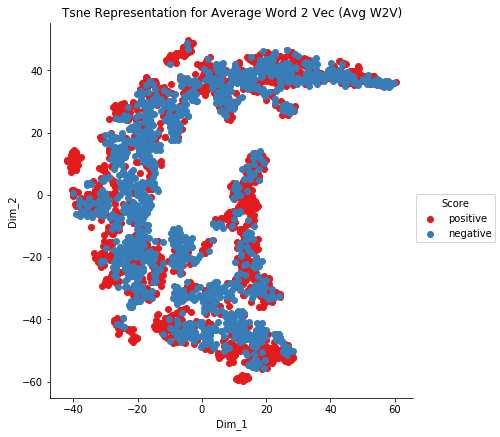

In [27]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_Aw2v = np.vstack((tsne_data_Aw2v.T, label)).T
tsne_data_Aw2v_df = pd.DataFrame(data=tsne_data_Aw2v, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_data_Aw2v_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for Average Word 2 Vec (Avg W2V)')
plt.show()

## TF-IDF - W2V 

In [28]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [29]:
#tsne perplexity=0
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data_tfidf_Aw2v = model.fit_transform(tfidf_sent_vectors)

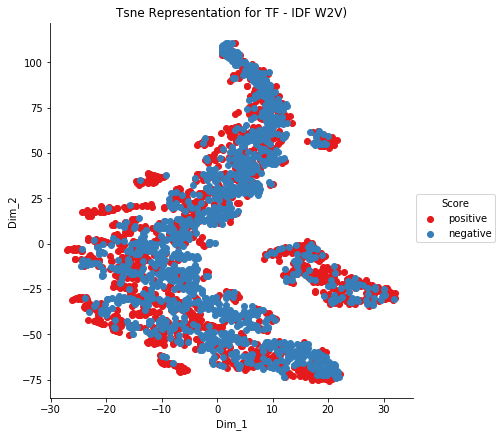

In [30]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_tfidf_Aw2v = np.vstack((tsne_data_tfidf_Aw2v.T, label)).T
tsne_data_tfidf_Aw2v_df = pd.DataFrame(data=tsne_data_tfidf_Aw2v, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_data_tfidf_Aw2v_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for TF - IDF W2V)')
plt.show()

In [31]:
#tsne with perplexity=30
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_data_tfidf_Aw2v = model.fit_transform(tfidf_sent_vectors)

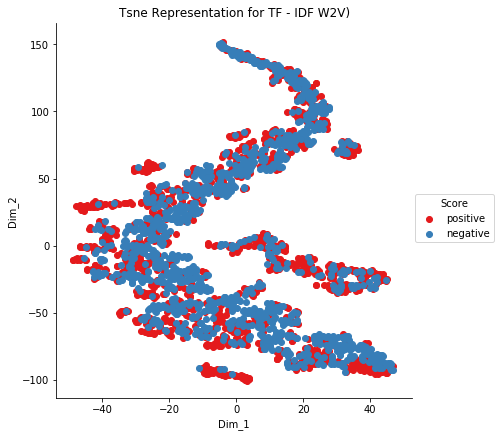

In [32]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_tfidf_Aw2v = np.vstack((tsne_data_tfidf_Aw2v.T, label)).T
tsne_data_tfidf_Aw2v_df = pd.DataFrame(data=tsne_data_tfidf_Aw2v, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_data_tfidf_Aw2v_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for TF - IDF W2V)')
plt.show()

In [33]:
#tsne with perplexity=40
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=5000)
tsne_data_tfidf_Aw2v = model.fit_transform(tfidf_sent_vectors)

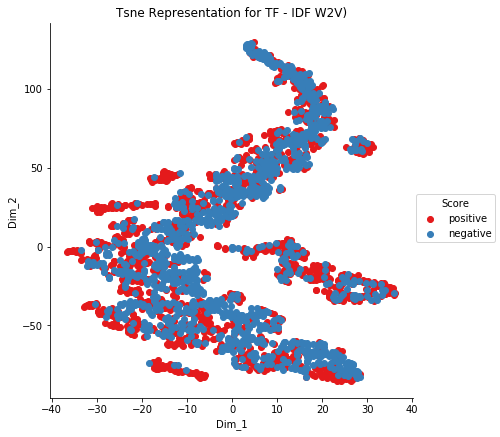

In [34]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_tfidf_Aw2v = np.vstack((tsne_data_tfidf_Aw2v.T, label)).T
tsne_data_tfidf_Aw2v_df = pd.DataFrame(data=tsne_data_tfidf_Aw2v, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_data_tfidf_Aw2v_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for TF - IDF W2V)')
plt.show()

In [35]:
#tsne with perplexity=50
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data_tfidf_Aw2v = model.fit_transform(tfidf_sent_vectors)

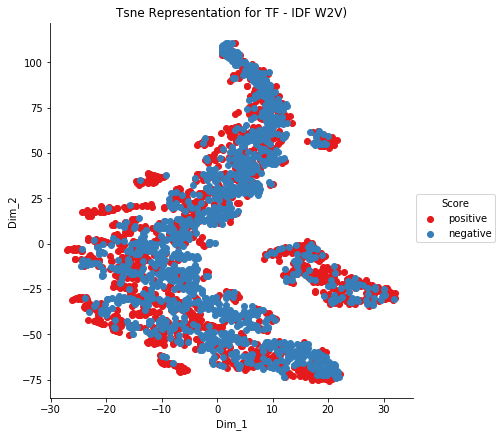

In [36]:
# Scatter plot representing 2 dimensions with the polarity
tsne_data_tfidf_Aw2v = np.vstack((tsne_data_tfidf_Aw2v.T, label)).T
tsne_data_tfidf_Aw2v_df = pd.DataFrame(data=tsne_data_tfidf_Aw2v, columns=("Dim_1", "Dim_2", "Score"))

sns.FacetGrid(tsne_data_tfidf_Aw2v_df, hue="Score", size=6,palette="Set1").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tsne Representation for TF - IDF W2V)')
plt.show()

<br> Conclusion <br>
    After plotting the Tsne plots for Bag of words, TF-IDF, Average W2v, TF-IDF W2V, came to conclusion that TF_IDF W2V plot is better to differentiate the Positive & Negative Reviews.
    
Note :- 1.25k Positive & 1.25k Negative data points are used due to memory Constraints